<a href="https://colab.research.google.com/github/szymonkulpinski/colab_notebooks/blob/main/teams_clustering_siglip2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if GPU is in use
If this command fails: click in the upper-right corner of this window 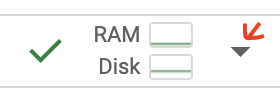
 and select `Change runtime type` and then select `T4 GPU`







In [1]:
!nvidia-smi

Sun Mar  9 11:41:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install all dependencies

In [2]:
!curl -LsSf https://astral.sh/uv/install.sh | sh

downloading uv 0.6.5 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


In [3]:
!uv pip install -q roboflow supervision umap-learn tqdm adjustText

In [4]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-hc4t3xsc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-hc4t3xsc
  Resolved https://github.com/huggingface/transformers to commit 94ae1ba5b55e79ba766582de8a199d8ccf24a021
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Make all the relevant imports

In [5]:
import os
import time
import pickle
import umap
import torch
import cv2
import warnings

import numpy as np
import seaborn as sns
import supervision as sv
import matplotlib.pyplot as plt

from tqdm import tqdm
from roboflow import Roboflow
from adjustText import adjust_text
from google.colab import userdata
from pathlib import Path
from sklearn.cluster import KMeans
from more_itertools import chunked
from typing import Tuple
from transformers import AutoFeatureExtractor, ResNetModel, AutoProcessor, SiglipVisionModel, CLIPProcessor, CLIPVisionModel, Siglip2VisionModel, AutoModel

### Define constants and settings


In [6]:
if 'google.colab' in str(get_ipython()):
  HOME = "/content"
else:
  HOME = os.getcwd()

# In the used dataset all of the images have the resolution of 1920x1080px
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Settings
NUM_ITERATIONS = 1 # set to 1 if you only want to evaluate once, for evalutation used 32
BATCH_SIZE_ARRAY = [32]
FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering" # where in google colab the experiments results should be saved
RUN_EXPERIMENTS = True # if set to true experiments will be run, if to false it will only read saved results

VERSIONS_TO_TEST = [
  "google/siglip2-base-patch32-256",
  "google/siglip2-base-patch16-224",
  "google/siglip2-base-patch16-256",
  "google/siglip2-base-patch16-384",
  "google/siglip2-base-patch16-512",
  "google/siglip2-base-patch16-naflex", # flexibel size?
  "google/siglip2-large-patch16-256",
  "google/siglip2-large-patch16-384",
  "google/siglip2-large-patch16-512",
  "google/siglip2-so400m-patch14-224",
  "google/siglip2-so400m-patch14-384",
  "google/siglip2-so400m-patch16-256",
  "google/siglip2-so400m-patch16-384",
  "google/siglip2-so400m-patch16-512",
  "google/siglip2-so400m-patch16-naflex",
  "google/siglip2-giant-opt-patch16-256",
  "google/siglip2-giant-opt-patch16-384", #17 modele
  "google/siglip-base-patch16-512",
  "google/siglip-base-patch16-384",
  "google/siglip-base-patch16-256",
  "google/siglip-base-patch16-224",
  "google/siglip-large-patch16-256",
  "google/siglip-large-patch16-384",
  "google/siglip-so400m-patch14-384",
  "google/siglip-so400m-patch14-224",
  "google/siglip-so400m-patch16-256-i18n",
  "microsoft/resnet-18",
  "microsoft/resnet-26",
  "microsoft/resnet-34",
  "microsoft/resnet-50",
  "microsoft/resnet-101",
  "microsoft/resnet-152",
  'openai/clip-vit-base-patch16',
  'openai/clip-vit-base-patch32',
  'openai/clip-vit-large-patch14',
  'openai/clip-vit-large-patch14-336',
]

# Ablation study settings
DO_ABLATION_STUDY = False
# BATCH_SIZE_ARRAY = [1,2,8,32] # values used in the ablation study


### Mount your google drive to google colab be able to save the results

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
Path(FOLDER_DIR).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the dataset and adjust the folder structure
If you haven't added your `ROBOFLOW_API_KEY` to your secrets in Google Colab, this code snippet will fail. Follow the instructions in this [Roboflow Notebook](https://colab.research.google.com/github/roboflow/sports/blob/main/examples/soccer/notebooks/train_player_detector.ipynb#scrollTo=BSd93ZJzZZKt) to add it.


In [8]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("szymon-kulpinski").project("football-players-clustering")
version = project.version(6)
dataset = version.download("yolov8") # use the format as the easier to work with then e.g. COCO
print(dataset.location)

!mv {dataset.location}/train/images/* {dataset.location}/train/
!mv {dataset.location}/train/labels/* {dataset.location}/train/
!rm -rdf {dataset.location}/train/images
!rm -rdf {dataset.location}/train/labels

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...
/content/datasets/football-players-clustering-6
mv: cannot stat '/content/datasets/football-players-clustering-6/train/images/*': No such file or directory
mv: cannot stat '/content/datasets/football-players-clustering-6/train/labels/*': No such file or directory


### Load the dataset as Supervision Detections

In [9]:
def convert_yolov8bbox_2_xyxy(xcycwh: np.ndarray) -> np.ndarray:
  # center_x center_y width height from https://roboflow.com/formats/yolov8-pytorch-txt.
  xcycwh[:,0] = xcycwh[:,0] * IMAGE_WIDTH
  xcycwh[:,1] = xcycwh[:,1] * IMAGE_HEIGHT
  xcycwh[:,2] = xcycwh[:,2] * IMAGE_WIDTH
  xcycwh[:,3] = xcycwh[:,3] * IMAGE_HEIGHT
  return sv.xcycwh_to_xyxy(xcycwh)

In [10]:
folder_path = Path(dataset.location)/ "train"
jpg_files = list(folder_path.glob('**/*.jpg'))
txt_files = [file.with_suffix('.txt') for file in jpg_files]

detections_list = []
for file in txt_files:
  data = np.loadtxt(str(file))
  class_id = data[:,0].astype(np.int32)
  xyxy = convert_yolov8bbox_2_xyxy(data[:,1:])
  detections_list.append(sv.Detections(xyxy=xyxy, class_id=class_id))
print(detections_list[0])

Detections(xyxy=array([[ 613.   ,  271.   ,  628.   ,  303.   ],
       [ 565.   ,  274.   ,  584.   ,  308.   ],
       [ 892.805,  280.495,  910.995,  318.005],
       [1138.   ,  266.   , 1160.   ,  307.   ],
       [ 719.   ,  306.   ,  733.   ,  349.   ],
       [ 826.   ,  341.   ,  843.   ,  385.   ],
       [1478.   ,  279.   , 1499.   ,  319.   ],
       [ 633.   ,  292.   ,  656.   ,  326.   ],
       [ 465.   ,  416.   ,  495.   ,  464.   ],
       [1193.   ,  312.   , 1210.   ,  353.   ],
       [ 481.445,  298.24 ,  498.995,  333.   ],
       [ 674.   ,  339.   ,  695.   ,  385.   ],
       [1258.   ,  283.   , 1278.   ,  326.   ],
       [1319.   ,  414.   , 1347.   ,  468.   ],
       [ 381.   ,  356.   ,  402.   ,  404.   ],
       [1282.   ,  447.   , 1305.   ,  504.   ],
       [ 947.   ,  540.   ,  970.   ,  604.   ],
       [ 415.   ,  508.   ,  444.   ,  565.   ],
       [ 476.175,  292.6  ,  492.725,  333.44 ],
       [ 890.84 ,  270.075,  910.82 ,  307.265]]), ma

### Visualise the detections on the image, double check if the conversion was successful


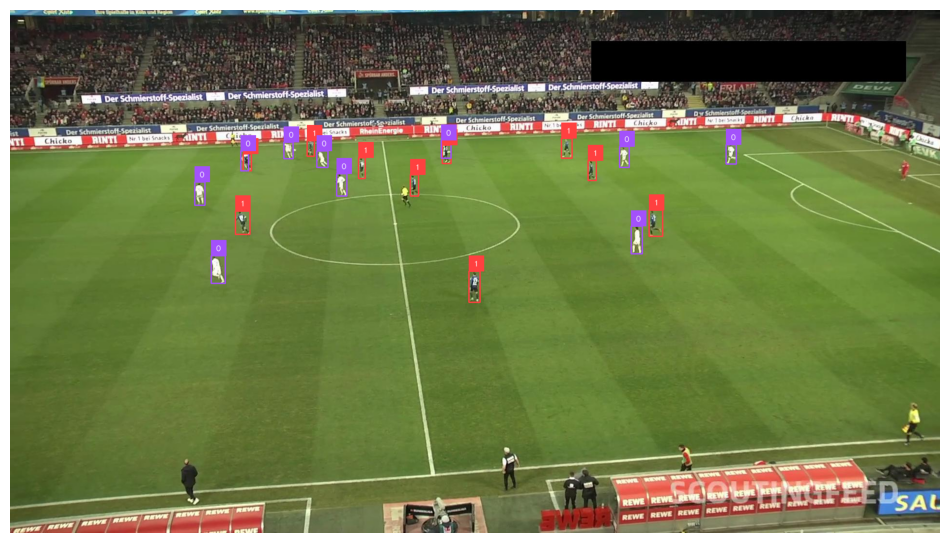

In [11]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
image= cv2.imread(str(jpg_files[0]))
detections = detections_list[0]
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)
sv.plot_image(image=annotated_image, size=(12, 12))

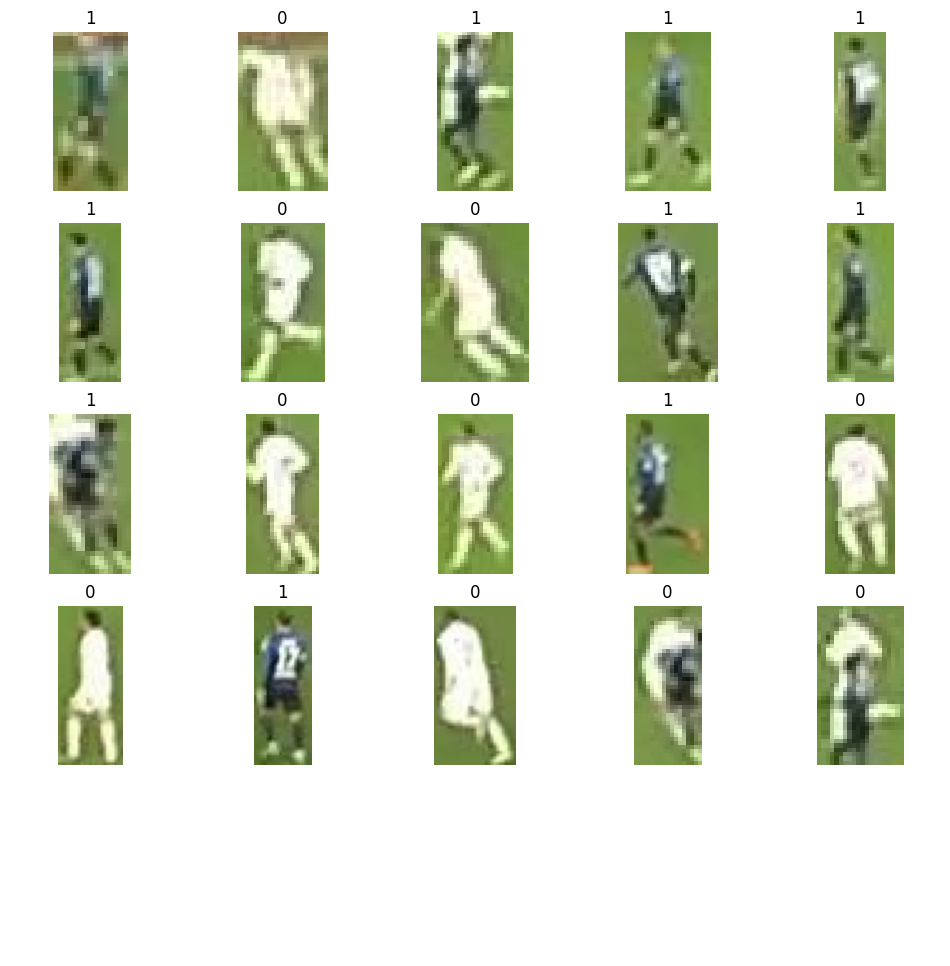

In [12]:
players_crops = [sv.crop_image(image, xyxy) for xyxy in detections.xyxy]
sv.plot_images_grid(players_crops, grid_size=(5,5), titles = [f"{i}" for i in detections_list[0].class_id])

### Define helper methods and class

In [25]:
class Experiment:
  def __init__(self, model_path: str):
    self.model_path = model_path
    self.model = None
    self.processor = None
    self.results_list = []
    self.clusters_list = []
    self.execution_time_list = []
    self.total_execution_time_list = []
    if "clip" in model_path:
      self.model_type = "CLIP"
    elif "siglip2" in model_path:
      self.model_type = "SIGLIP2"
    elif "siglip" in model_path:
      self.model_type = "SIGLIP"
    elif "resnet" in model_path:
      self.model_type = "RESNET"
    else:
      raise ValueError("Unknown model type")


  def init_model_n_processor(self):
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    if self.model_type == "CLIP":
      self.model = CLIPVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "SIGLIP2":
      # print("working 1")
      self.model = AutoModel.from_pretrained(self.model_path, device_map=DEVICE).eval()
      # self.model = Siglip2VisionModel.from_pretrained(self.model_path).to(DEVICE)
      # print("working 2")

      self.processor = AutoProcessor.from_pretrained(self.model_path)
      # print("working 3")

    elif self.model_type == "SIGLIP":
      self.model = SiglipVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "RESNET":
      self.model = ResNetModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoFeatureExtractor.from_pretrained(self.model_path)


  def forward(self, batch: np.ndarray) -> np.ndarray:
    with torch.no_grad():
      inputs = self.processor(images=batch, return_tensors="pt").to(DEVICE)
      if self.model_type == "SIGLIP2":
        embeddings = self.model.get_image_features(**inputs).cpu().numpy()
      else:
        outputs = self.model(**inputs)
        if self.model_type == "RESNET":
          embeddings = torch.mean(outputs.last_hidden_state, dim=[2, 3]).cpu().numpy()
        else:
          embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
      return embeddings


  def clean_up(self):
    self.model = None
    self.processor = None


In [26]:
def get_best_results_n_clusters(b_clusters: np.ndarray, b_class_id: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
  '''
    Compares predicted clusters (b_clusters) with ground truth class IDs (b_class_id)
    and potentially inverts the clusters to achieve the best possible accuracy.

    Setting all predictions to 1 or 0 will have at least a 50% success rate,
    so the classifier cannot perform worse than that.
    The assignment of cluster 0 and cluster 1 is arbitrary.
    Inverting the results to the "best result" corresponds to actual classification results.

    Args:
        b_clusters (np.ndarray): Predicted cluster assignments (0 or 1).
        b_class_id (np.ndarray): Ground truth class IDs (0 or 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - A boolean array indicating whether each prediction is correct after potential inversion.
            - The cluster assignments (0 or 1) after potential inversion.
  '''

  result = b_clusters == b_class_id
  if result.sum() < len(clusters)/2:
    b_clusters = ~b_clusters
    result = b_clusters == b_class_id
  return result, b_clusters.astype(np.int32)

def save_results_to_google_drive(experiments_list: list, batch_size: int, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  with open(filename, 'wb') as f:
    pickle.dump(experiments_list, f)

def load_results_from_google_drive(batch_size: list, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  loaded_experiment_list = None
  with open(filename, 'rb') as f:
    loaded_experiment_list = pickle.load(f)
  return loaded_experiment_list


### Init methods

In [27]:
Umap_reducer = umap.UMAP(n_components=3)
KMeans_model = KMeans(n_clusters=2)

### Run the evaluation and save the results to your google drive for future evaluation

In [28]:
if RUN_EXPERIMENTS:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for iteration in range(NUM_ITERATIONS):
    print("Iteration: ", iteration)
    experiments_list = [Experiment(model_path) for model_path in VERSIONS_TO_TEST] # prevent appending into infinity, create objects anew
    for batch_size in BATCH_SIZE_ARRAY:
      for k, exp in enumerate(experiments_list):
        print("Model:", exp.model_path)
        print("Batch size:", batch_size)
        exp.init_model_n_processor()
        for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
            image = cv2.imread(str(image_path))
            players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
            pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
            batches = chunked(pillow_crops, batch_size)

            data = []
            start_time = time.perf_counter()
            for batch in batches:
              data.append(exp.forward(batch))
            end_time = time.perf_counter()
            exp.execution_time_list.append(end_time - start_time)

            data = np.concatenate(data)
            projections = Umap_reducer.fit_transform(data)
            clusters = np.array(KMeans_model.fit_predict(projections))

            total_time = time.perf_counter()
            exp.total_execution_time_list.append(total_time - start_time)

            result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
            exp.results_list.append(result.sum() / len(clusters))
            exp.clusters_list.append(clusters)
        exp.clean_up()
        experiments_list[k] = exp

        print("Mean accuracy: ", np.mean(exp.results_list))
        print("Mean execution time: ", np.mean(exp.execution_time_list))
        print("Mean FPS: ", 1/np.mean(exp.execution_time_list))
        print("Double check exp.results_list length: ", len(exp.results_list))
        print(exp.results_list)
        print("\n")

      save_results_to_google_drive(experiments_list, iteration, is_iteration=True)

Iteration:  0
Model: google/siglip2-base-patch32-256
Batch size: 32
working 1
working 2
working 3


per image: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Mean accuracy:  0.7516985645933013
Mean execution time:  0.164942403379996
Mean FPS:  6.062722377678648
Double check exp.results_list length:  50
[0.9, 1.0, 1.0, 0.55, 0.55, 0.65, 0.55, 0.8421052631578947, 0.9, 0.7368421052631579, 1.0, 0.5, 0.9, 0.65, 1.0, 1.0, 0.9, 0.55, 1.0, 0.75, 0.85, 1.0, 0.7, 0.5454545454545454, 0.6, 0.7, 1.0, 0.7, 0.5263157894736842, 0.85, 0.95, 0.5, 0.65, 0.65, 0.65, 0.55, 1.0, 0.6, 0.55, 0.6, 0.6842105263157895, 0.95, 0.55, 0.55, 1.0, 0.65, 1.0, 1.0, 0.55, 0.55]


Model: google/siglip2-base-patch16-224
Batch size: 32
working 1


config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


Mean accuracy:  0.723098351940457
Mean execution time:  0.2335621932199956
Mean FPS:  4.281514855694498
Double check exp.results_list length:  50
[0.7, 0.85, 0.85, 0.6, 0.55, 0.95, 0.5, 0.8421052631578947, 0.6, 0.6842105263157895, 0.8888888888888888, 0.65, 0.8, 0.6, 0.7, 0.9, 0.8, 0.7, 1.0, 0.85, 0.7, 0.7, 0.75, 0.6818181818181818, 0.75, 0.6, 0.65, 0.65, 0.5263157894736842, 0.95, 0.9, 0.55, 0.75, 0.85, 0.55, 0.5, 0.6, 0.65, 0.55, 0.9, 0.631578947368421, 0.95, 0.6, 0.55, 0.75, 0.8, 0.9, 1.0, 0.55, 0.65]


Model: google/siglip2-base-patch16-256
Batch size: 32
working 1


config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


Mean accuracy:  0.70096331738437
Mean execution time:  0.3028374637999968
Mean FPS:  3.3021013564571087
Double check exp.results_list length:  50
[0.75, 0.75, 0.85, 0.6, 0.6, 0.5, 0.5, 0.9473684210526315, 0.6, 0.6842105263157895, 0.8333333333333334, 0.5, 1.0, 0.6, 0.7, 0.75, 0.9, 0.5, 0.6, 0.75, 0.75, 0.75, 0.7, 0.7727272727272727, 0.75, 0.6, 0.5, 0.7, 0.5263157894736842, 0.65, 0.6, 0.55, 0.65, 0.75, 0.55, 0.85, 1.0, 0.5, 0.55, 0.8, 0.6842105263157895, 0.95, 0.75, 0.55, 0.9, 0.85, 0.9, 0.85, 0.6, 0.6]


Model: google/siglip2-base-patch16-384
Batch size: 32
working 1


config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Mean accuracy:  0.7152158426368953
Mean execution time:  0.7728339654400179
Mean FPS:  1.2939389891212192
Double check exp.results_list length:  50
[0.7, 0.75, 1.0, 0.6, 0.55, 0.75, 0.5, 0.8947368421052632, 0.95, 0.6842105263157895, 0.7777777777777778, 0.6, 0.55, 1.0, 0.9, 0.95, 0.9, 0.55, 1.0, 0.7, 0.7, 0.6, 0.7, 0.5909090909090909, 0.6, 0.65, 0.7, 0.6, 0.5789473684210527, 0.75, 0.6, 0.75, 0.75, 0.85, 0.55, 0.6, 0.75, 0.55, 0.55, 0.85, 0.6842105263157895, 0.9, 0.7, 0.5, 0.75, 0.8, 0.6, 1.0, 0.7, 0.55]


Model: google/siglip2-base-patch16-512
Batch size: 32
working 1


config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


Mean accuracy:  0.705555023923445
Mean execution time:  1.5173516845800032
Mean FPS:  0.6590429958739565
Double check exp.results_list length:  50
[0.75, 0.75, 0.95, 0.55, 0.55, 0.5, 0.5, 0.7894736842105263, 0.5, 0.6842105263157895, 1.0, 0.6, 0.55, 0.7, 0.6, 0.95, 0.85, 0.65, 0.95, 0.8, 0.7, 0.5, 0.6, 0.5909090909090909, 0.65, 0.55, 1.0, 0.65, 0.5789473684210527, 0.8, 0.55, 0.6, 0.7, 0.8, 0.55, 0.6, 1.0, 0.55, 0.6, 0.85, 0.6842105263157895, 0.9, 0.75, 0.5, 0.8, 0.8, 0.9, 1.0, 0.65, 0.7]


Model: google/siglip2-base-patch16-naflex
Batch size: 32
working 1


config.json:   0%|          | 0.00/329 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Mean accuracy:  0.745920255183413
Mean execution time:  0.3022198321399901
Mean FPS:  3.308849696987436
Double check exp.results_list length:  50
[0.5, 0.8, 0.9, 0.8, 0.95, 1.0, 0.55, 0.6842105263157895, 0.95, 0.7368421052631579, 0.8333333333333334, 0.65, 0.55, 0.5, 0.95, 0.55, 0.75, 1.0, 0.8, 0.55, 0.75, 0.8, 0.85, 0.6363636363636364, 0.8, 0.75, 1.0, 0.65, 0.5789473684210527, 0.85, 0.65, 0.55, 0.95, 0.7, 0.6, 0.85, 1.0, 0.55, 0.55, 0.7, 0.5263157894736842, 0.8, 0.7, 0.6, 0.75, 0.95, 0.75, 0.95, 0.85, 0.65]


Model: google/siglip2-large-patch16-256
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


Mean accuracy:  0.6275023923444976
Mean execution time:  0.9663976070999933
Mean FPS:  1.0347707741131957
Double check exp.results_list length:  50
[0.55, 0.55, 0.55, 0.5, 0.65, 0.95, 0.5, 0.8421052631578947, 0.55, 0.7368421052631579, 0.5, 0.55, 0.5, 0.6, 0.6, 0.55, 0.7, 1.0, 0.55, 0.65, 0.6, 0.65, 0.8, 0.5909090909090909, 0.55, 0.7, 0.65, 0.6, 0.5263157894736842, 0.7, 0.65, 0.65, 0.7, 0.75, 0.6, 0.5, 0.6, 0.5, 0.55, 0.55, 0.5789473684210527, 0.7, 0.6, 0.6, 0.5, 0.65, 0.7, 0.7, 0.65, 0.7]


Model: google/siglip2-large-patch16-384
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


Mean accuracy:  0.6687713981924509
Mean execution time:  2.307960402780018
Mean FPS:  0.43328299688134403
Double check exp.results_list length:  50
[0.6, 0.6, 0.7, 0.55, 0.75, 0.9, 0.5, 0.8947368421052632, 0.55, 0.7368421052631579, 0.5555555555555556, 0.55, 0.5, 0.5, 0.9, 0.5, 0.85, 1.0, 0.65, 0.85, 0.6, 0.7, 0.6, 0.5909090909090909, 0.5, 0.65, 0.8, 0.7, 0.631578947368421, 0.9, 0.5, 0.75, 0.7, 0.95, 0.55, 0.75, 0.55, 0.5, 0.55, 0.55, 0.5789473684210527, 0.7, 0.6, 0.6, 0.55, 0.7, 0.85, 0.65, 0.8, 0.75]


Model: google/siglip2-large-patch16-512
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [03:41<00:00,  4.44s/it]


Mean accuracy:  0.6826459330143542
Mean execution time:  4.379341312740021
Mean FPS:  0.2283448419722121
Double check exp.results_list length:  50
[0.7, 0.7, 0.75, 0.65, 0.7, 0.95, 0.55, 0.9473684210526315, 0.55, 0.6842105263157895, 1.0, 0.6, 0.65, 0.55, 0.8, 0.7, 0.8, 0.7, 1.0, 0.75, 0.7, 0.75, 0.55, 0.5454545454545454, 0.55, 0.65, 0.65, 0.65, 0.5263157894736842, 0.85, 0.55, 0.5, 0.75, 0.55, 0.55, 0.55, 0.55, 0.55, 0.5, 0.55, 0.5789473684210527, 0.7, 0.6, 0.6, 0.9, 0.9, 0.75, 0.85, 0.75, 0.75]


Model: google/siglip2-so400m-patch14-224
Batch size: 32
working 1


config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


Mean accuracy:  0.6608942052099946
Mean execution time:  1.296585507919999
Mean FPS:  0.771256499391401
Double check exp.results_list length:  50
[0.7, 0.5, 0.65, 0.8, 0.55, 0.95, 0.5, 0.7368421052631579, 0.55, 0.6842105263157895, 0.7222222222222222, 0.65, 0.55, 0.55, 0.55, 0.55, 0.75, 1.0, 0.6, 0.7, 0.7, 0.6, 0.7, 0.5909090909090909, 1.0, 0.75, 0.75, 0.55, 0.631578947368421, 1.0, 0.8, 0.6, 0.7, 0.85, 0.65, 0.7, 0.75, 0.5, 0.55, 0.5, 0.5789473684210527, 0.65, 0.55, 0.5, 0.55, 0.6, 0.65, 0.5, 0.75, 0.6]


Model: google/siglip2-so400m-patch14-384
Batch size: 32
working 1


config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [03:30<00:00,  4.22s/it]


Mean accuracy:  0.6469909622541202
Mean execution time:  4.165559833959996
Mean FPS:  0.24006377050389127
Double check exp.results_list length:  50
[0.7, 0.6, 0.7, 0.65, 0.5, 0.95, 0.5, 0.5789473684210527, 0.55, 0.7368421052631579, 0.7777777777777778, 0.5, 0.6, 0.55, 0.95, 0.6, 0.85, 1.0, 0.7, 0.75, 0.7, 0.6, 0.7, 0.5454545454545454, 0.55, 0.6, 0.95, 0.6, 0.631578947368421, 0.6, 0.6, 0.55, 0.7, 0.65, 0.55, 0.55, 0.6, 0.55, 0.6, 0.6, 0.5789473684210527, 0.8, 0.65, 0.5, 0.55, 0.55, 0.7, 0.55, 0.6, 0.7]


Model: google/siglip2-so400m-patch16-256
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


Mean accuracy:  0.6745667198298777
Mean execution time:  1.3102426082600505
Mean FPS:  0.7632174329363016
Double check exp.results_list length:  50
[0.6, 0.55, 0.6, 0.65, 0.7, 1.0, 0.55, 0.8421052631578947, 0.8, 0.631578947368421, 0.6111111111111112, 0.7, 0.6, 0.5, 0.95, 0.7, 0.75, 1.0, 0.9, 0.75, 0.7, 0.5, 0.7, 0.5909090909090909, 1.0, 0.65, 0.75, 0.55, 0.5263157894736842, 0.9, 0.65, 0.55, 0.75, 0.9, 0.6, 0.55, 0.5, 0.5, 0.6, 0.7, 0.5263157894736842, 0.65, 0.55, 0.5, 0.6, 0.6, 0.7, 0.55, 0.85, 0.65]


Model: google/siglip2-so400m-patch16-384
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


Mean accuracy:  0.6698883572567783
Mean execution time:  3.495221833299993
Mean FPS:  0.28610487336532114
Double check exp.results_list length:  50
[0.65, 0.55, 0.5, 0.5, 0.55, 1.0, 0.55, 0.8947368421052632, 0.55, 0.6842105263157895, 0.6666666666666666, 0.65, 0.55, 0.6, 0.95, 0.7, 0.8, 1.0, 0.7, 0.75, 0.7, 0.5, 0.7, 0.5909090909090909, 1.0, 0.6, 0.7, 0.55, 0.5789473684210527, 0.7, 0.8, 0.55, 0.5, 0.95, 0.5, 0.55, 0.7, 0.55, 0.5, 0.65, 0.5789473684210527, 0.75, 0.7, 0.55, 0.6, 0.95, 0.7, 0.6, 0.85, 0.55]


Model: google/siglip2-so400m-patch16-512
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [05:10<00:00,  6.21s/it]


Mean accuracy:  0.6476310473152579
Mean execution time:  6.1555410381799724
Mean FPS:  0.16245525678367875
Double check exp.results_list length:  50
[0.7, 0.7, 0.75, 0.65, 0.7, 0.75, 0.5, 0.631578947368421, 0.55, 0.631578947368421, 0.7222222222222222, 0.55, 0.5, 0.55, 0.95, 0.8, 0.65, 1.0, 0.5, 0.7, 0.7, 0.55, 0.65, 0.5909090909090909, 0.6, 0.7, 0.55, 0.55, 0.5263157894736842, 1.0, 0.6, 0.55, 0.5, 1.0, 0.5, 0.55, 0.6, 0.5, 0.55, 0.5, 0.5789473684210527, 0.75, 0.65, 0.55, 0.55, 0.65, 0.8, 0.55, 0.85, 0.7]


Model: google/siglip2-so400m-patch16-naflex
Batch size: 32
working 1


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

working 2


preprocessor_config.json:   0%|          | 0.00/393 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


Mean accuracy:  0.8237400318979266
Mean execution time:  1.290703881160025
Mean FPS:  0.7747710490350785
Double check exp.results_list length:  50
[0.75, 0.55, 0.95, 1.0, 0.65, 1.0, 0.8, 0.8947368421052632, 0.95, 0.7894736842105263, 0.6666666666666666, 0.65, 0.95, 0.6, 1.0, 0.85, 0.85, 1.0, 0.95, 0.9, 0.95, 0.55, 0.55, 0.9545454545454546, 1.0, 0.55, 0.85, 0.5, 1.0, 1.0, 0.95, 0.7, 1.0, 1.0, 0.7, 1.0, 0.8, 0.5, 0.6, 0.95, 0.631578947368421, 0.6, 0.95, 0.75, 0.9, 1.0, 1.0, 0.8, 0.75, 0.95]


Model: google/siglip2-giant-opt-patch16-256
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/101k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [02:51<00:00,  3.44s/it]


Mean accuracy:  0.6707448165869218
Mean execution time:  3.3848675242599984
Mean FPS:  0.2954325369701494
Double check exp.results_list length:  50
[0.7, 0.65, 0.85, 0.9, 0.5, 1.0, 0.6, 0.631578947368421, 0.55, 0.7368421052631579, 0.6666666666666666, 0.65, 0.6, 0.55, 0.75, 0.55, 0.65, 1.0, 0.8, 0.55, 0.65, 0.5, 0.75, 0.6363636363636364, 0.95, 0.65, 0.6, 0.5, 0.631578947368421, 0.9, 0.5, 0.6, 0.8, 0.9, 0.6, 0.55, 0.75, 0.65, 0.5, 0.65, 0.6842105263157895, 0.55, 0.5, 0.85, 0.5, 0.7, 0.5, 0.7, 0.9, 0.5]


Model: google/siglip2-giant-opt-patch16-384
Batch size: 32
working 1


config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/101k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

working 2


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

working 3


per image: 100%|██████████| 50/50 [06:40<00:00,  8.00s/it]


Mean accuracy:  0.7231834130781499
Mean execution time:  7.947720350899999
Mean FPS:  0.12582224283806867
Double check exp.results_list length:  50
[0.7, 0.8, 1.0, 0.6, 0.65, 0.9, 0.6, 0.6842105263157895, 1.0, 0.7368421052631579, 0.8333333333333334, 0.85, 0.5, 0.6, 0.8, 0.5, 0.8, 1.0, 0.85, 0.9, 0.65, 0.6, 0.75, 0.6363636363636364, 1.0, 0.6, 0.8, 0.55, 0.7894736842105263, 0.85, 0.7, 0.6, 0.75, 0.9, 0.9, 0.55, 0.95, 0.6, 0.55, 0.9, 0.5789473684210527, 0.55, 0.55, 0.65, 0.55, 0.55, 0.75, 0.75, 0.8, 0.5]




#### Visualise one of the results for some or all of the images for the last experiment


Score:  0.5


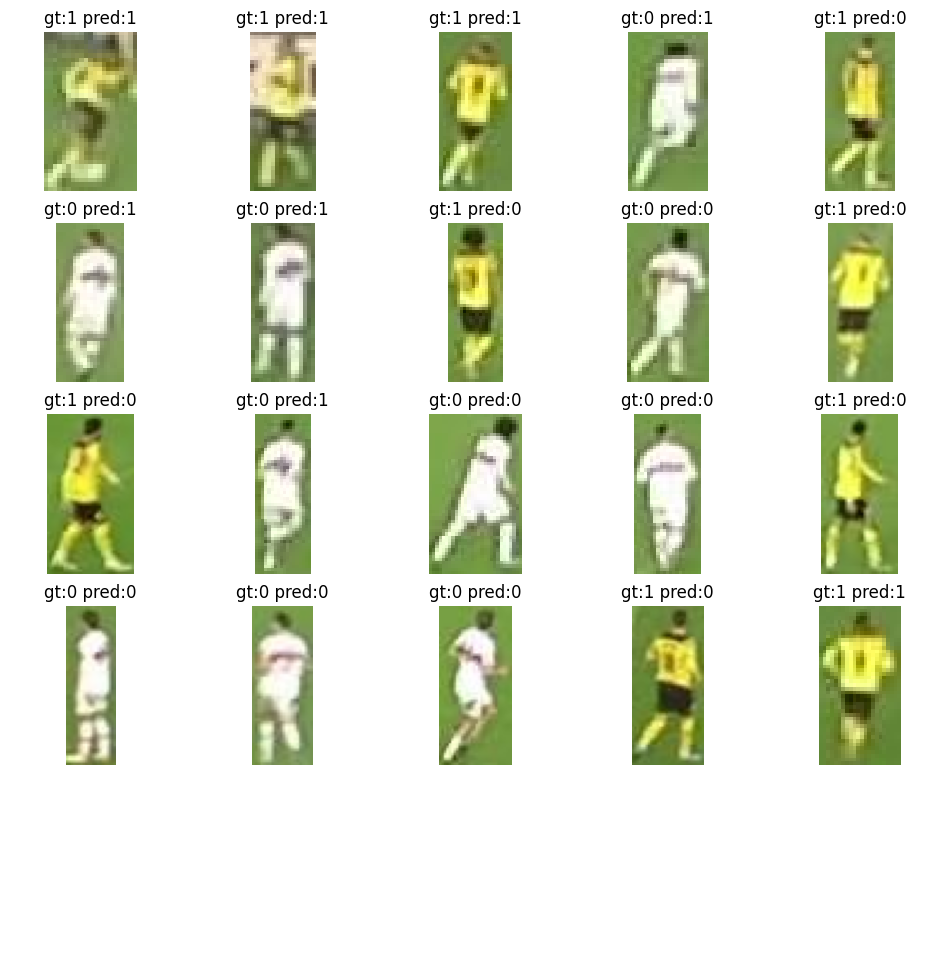

In [29]:
def display_for_id(id: int, exp: Experiment):
  image = cv2.imread(str(jpg_files[id]))
  players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[id].xyxy]
  print("Score: ", exp.results_list[id])
  sv.plot_images_grid(players_crops, grid_size=(5,5),
                      titles = [f"gt:{i} pred:{j}" for i,j in zip(detections_list[id].class_id,exp.clusters_list[id])])

try:
  # display_for_id(np.argmax(exp.results_list), exp)
  display_for_id(np.argmin(exp.results_list), exp)
  # for id in range(len(exp.results_list)):
  #   display_for_id(id, exp)
except NameError:
  print("No experiment was run therfore the plot won't work")


# Evaluation


### Prepare the data

In [39]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

num_images = len(all_experiments_for_all_iterations[0][0].results_list)
rows = NUM_ITERATIONS * num_images
accuracy_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
accuracy_array_3D = np.zeros((len(VERSIONS_TO_TEST), NUM_ITERATIONS, num_images))
exec_time_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
total_exec_time_array = np.zeros((rows, len(VERSIONS_TO_TEST)))
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    accuracy_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.results_list
    accuracy_array_3D[i_exp,i_batch,:] = current_exp.results_list
    exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.execution_time_list
    total_exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.total_execution_time_list
  model_name_list.append(current_exp.model_path)

mean_total_exec_speed_array = 1/np.mean(total_exec_time_array, axis=0)


# Prepare naming for the plots
method_names = model_name_list
method_names = [name.split('/')[-1] for name in method_names] # remove everything before the forward slash
method_names = [name.replace('base', 'b').replace('large', 'l').replace('resnet', 'ResNet').replace('siglip', 'SigLip').replace('clip', 'CLIP').replace('patch', 'p').replace('-vit', '') for name in method_names] # rename the parts of the names
colors = ['c' if 'SigLip2' in name else 'g' if 'SigLip' in name else 'r' if 'ResNet' in name else 'b' for name in method_names]
markers = ['s' if 'SigLip2' in name else  'o' if 'SigLip' in name else '*' if 'ResNet' in name else 'x' for name in method_names]


## Boxplots with accuracy and total execution time

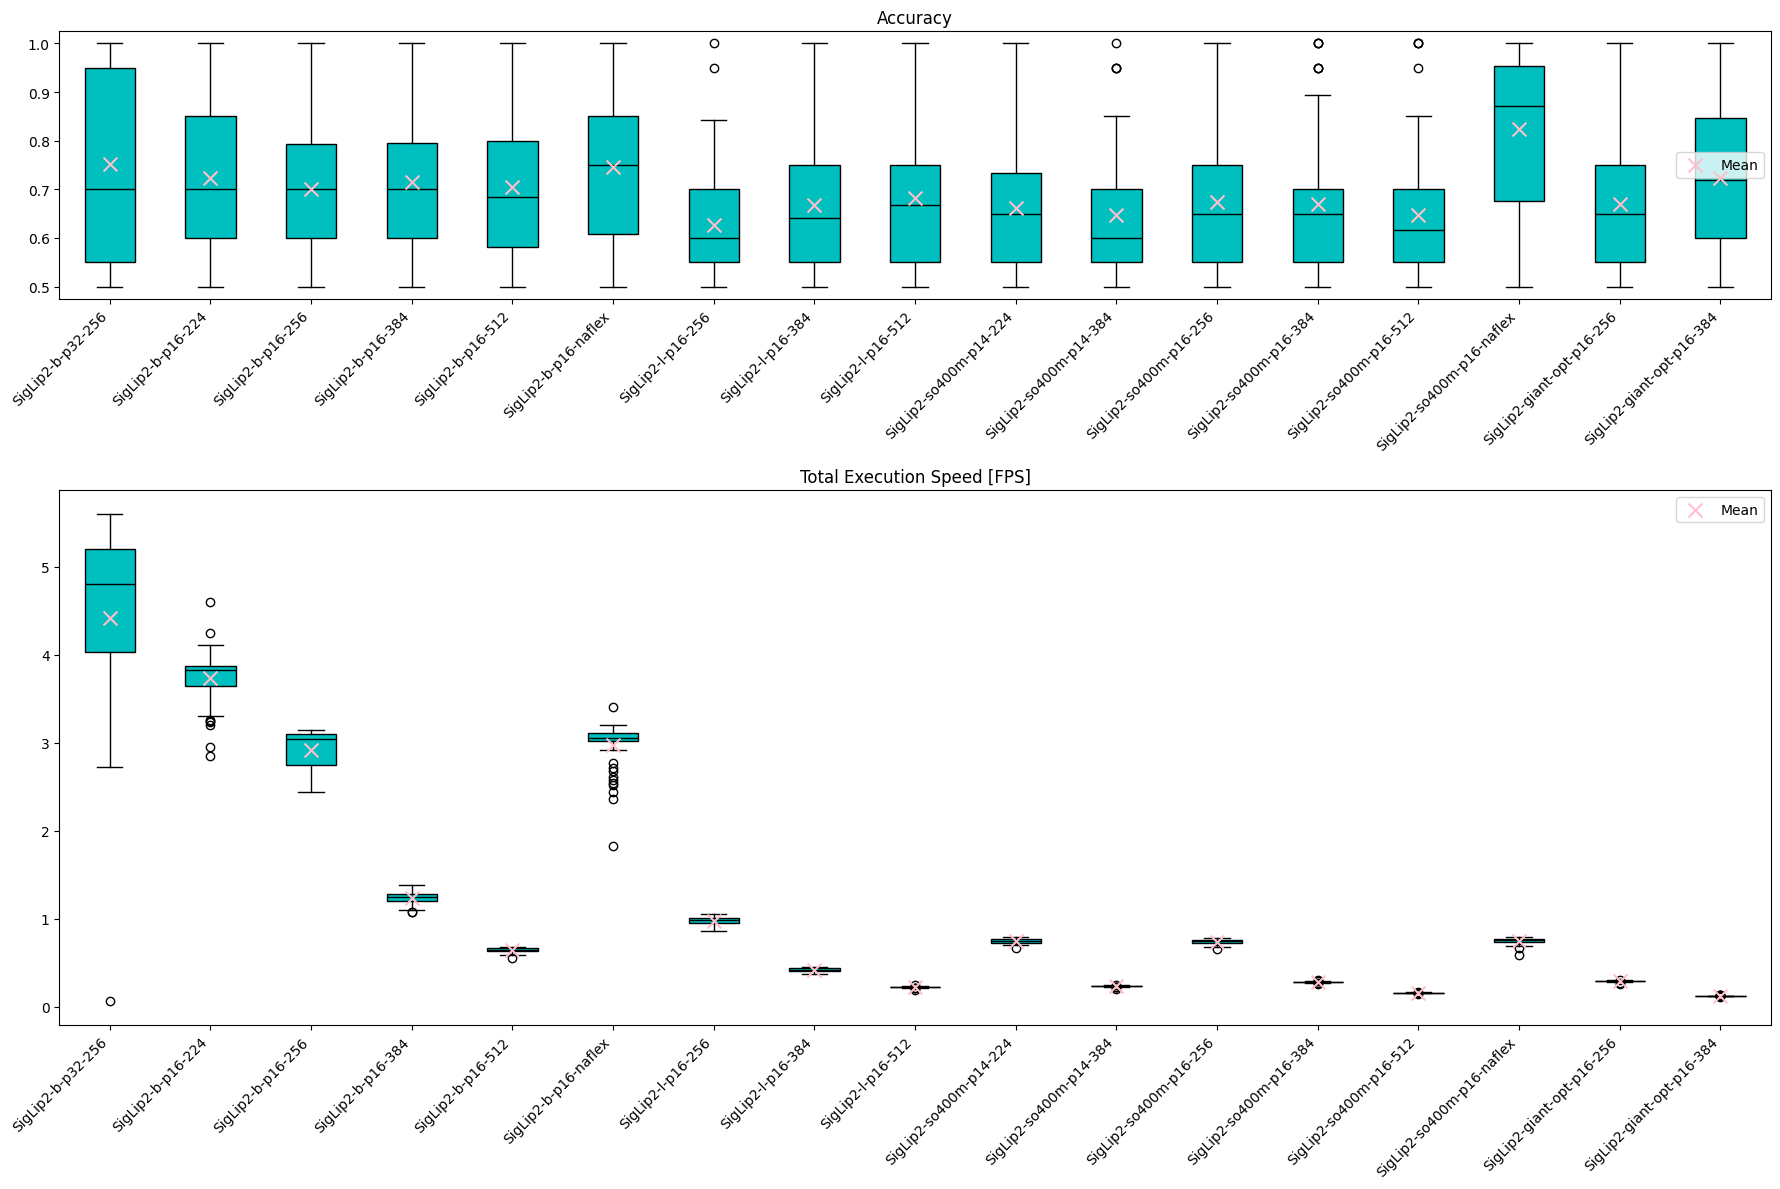

In [40]:
# Create a figure and axes for the boxplots
fig, axes = plt.subplots(2, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [1, 2]})  # Adjust height ratios


# --- Accuracy ---
bp1 = axes[0].boxplot(accuracy_array, patch_artist=True, medianprops=dict(color="black")) # patch_artist=True to be able to color the boxes
axes[0].set_title('Accuracy')
axes[0].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp1['boxes'], colors):
    box.set_facecolor(color)


# --- Total Execution Time ---
bp3 = axes[1].boxplot(1/total_exec_time_array, patch_artist=True, medianprops=dict(color="black"))
axes[1].set_title('Total Execution Speed [FPS]')
axes[1].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp3['boxes'], colors):
    box.set_facecolor(color)


# Calculate and plot average values for Accuracy
means_acc = np.mean(accuracy_array, axis=0)
axes[0].scatter(np.arange(1, len(method_names) + 1), means_acc, marker='x', color='pink', s=100, label='Mean', zorder=10)
means_total_exec = np.mean(1/total_exec_time_array, axis=0)
axes[1].scatter(np.arange(1, len(method_names) + 1), means_total_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)


for ax in axes:
  ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Summary: Mean Results Plot

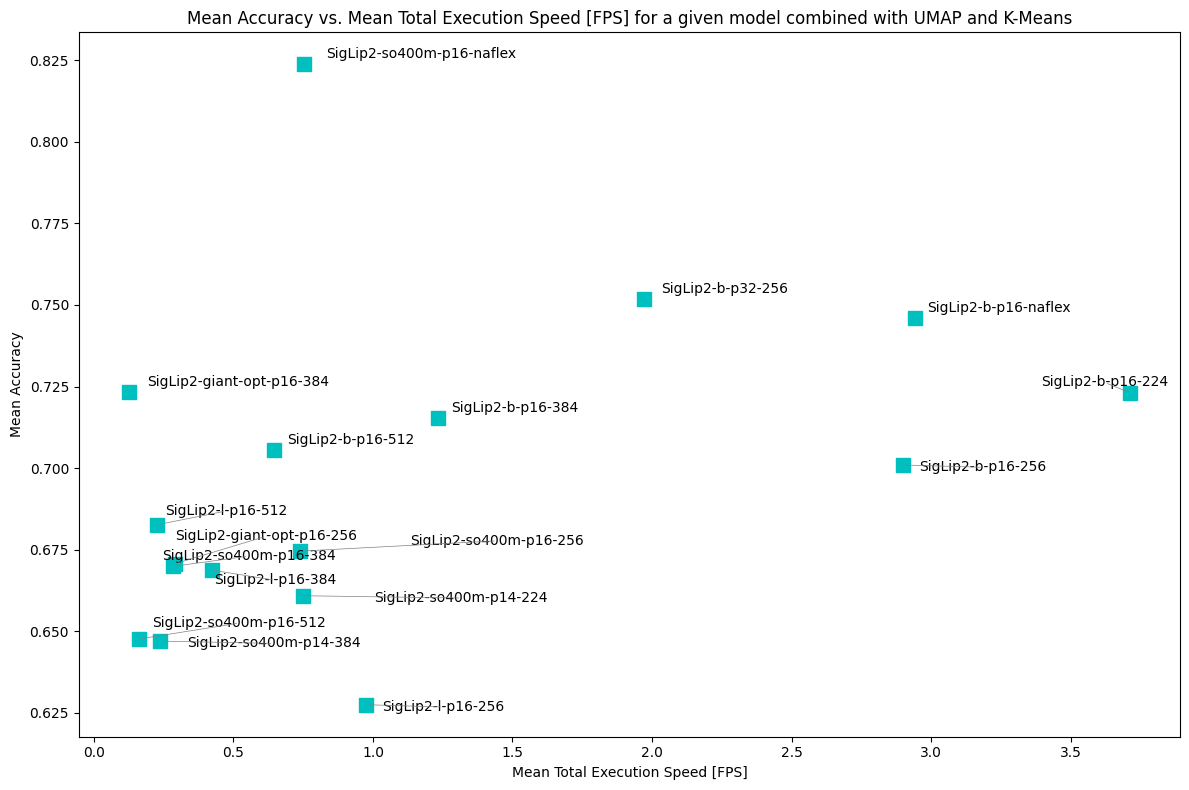

In [41]:
# Calculate mean accuracy for each model
mean_accuracy_array = np.mean(accuracy_array, axis=0)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))


for i in range(len(method_names)):
    markersize = 8 if markers[i] == 'o' else 10  # Smaller circles
    linewidth = 2 if markers[i] == 'x' else 1  # Thicker crosses
    ax.scatter(mean_total_exec_speed_array[i], mean_accuracy_array[i],
               color=colors[i], marker=markers[i], label=method_names[i],
               s=markersize**2, linewidth=linewidth)  # s=markersize**2 for area scaling

# Use adjust_text to prevent label overlap
texts = []
siglip_crowded = []
for i, txt in enumerate(method_names):
    if 'SigLip' in txt and 'SigLip-b' not in txt:
      siglip_crowded.append(ax.text(mean_total_exec_speed_array[i], mean_accuracy_array[i], txt))
    else:
      texts.append(ax.text(mean_total_exec_speed_array[i], mean_accuracy_array[i], txt))

adjust_text(texts,
            expand_points=(2, 2),  # Increase space around points
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )
adjust_text(siglip_crowded,
            expand_points=(2, 2),  # Increase space around points
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), # Add gray arrows
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )

# Set plot labels and title
ax.set_xlabel('Mean Total Execution Speed [FPS]')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy vs. Mean Total Execution Speed [FPS] for a given model combined with UMAP and K-Means')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Repeatability

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Mean accuracy diff:  0.0
Mean time diff:  0.0
Max accuracy diff:  0.0
Max time diff:  0.0
Min accuracy diff:  0.0
Min time diff:  0.0


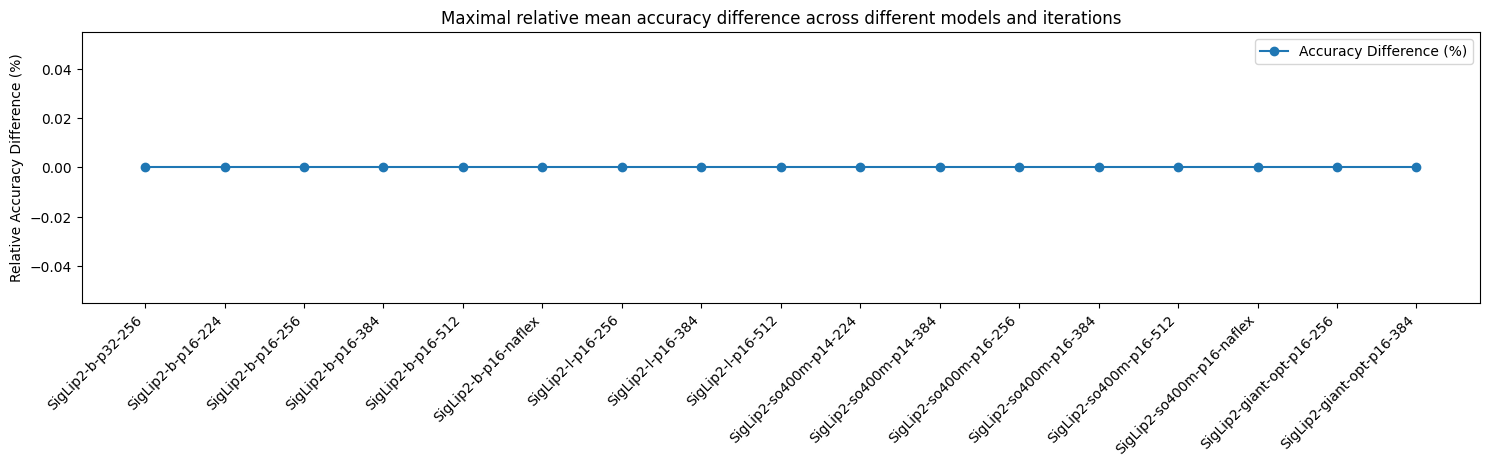

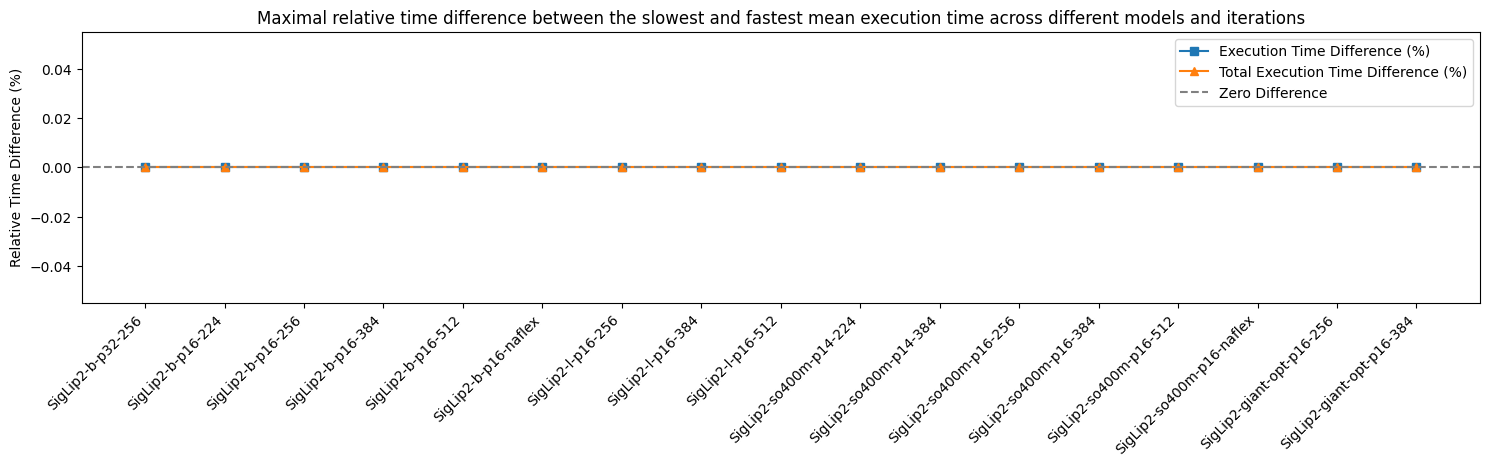

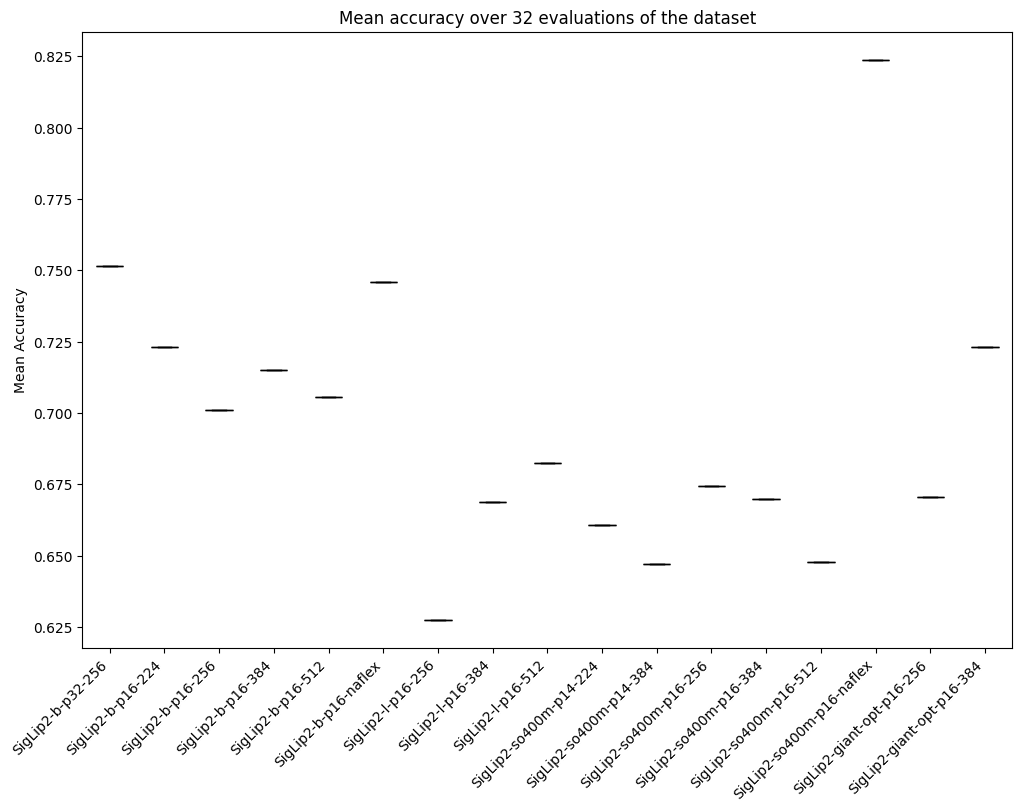

In [33]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
show_plot_for_each_exp = False
show_percentage_differences = True
show_percentage_differences_text = False

accuracy_diff_list = []
exec_time_diff_list = []
total_exec_time_diff_list = []
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  mean_results_list = []
  mean_exec_time_list = []
  mean_total_exec_time_list = []
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    mean_results_list.append(np.mean(current_exp.results_list))
    mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
    mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

  if show_plot_for_each_exp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    ax1.plot(NUM_ITERATIONS_ARRAY, mean_results_list, label="Mean Accuracy")
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Mean Accuracy')
    ax1.legend()

    ax2.plot(NUM_ITERATIONS_ARRAY, mean_exec_time_list, label="Mean Exec time")
    ax2.plot(NUM_ITERATIONS_ARRAY, mean_total_exec_time_list, label="Mean Total Exec time")
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Mean Execution Time')
    ax2.legend()

    fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
    plt.show()

  if show_percentage_differences:
    mean_results_list = np.array(mean_results_list)
    mean_exec_time_list = np.array(mean_exec_time_list)
    mean_total_exec_time_list = np.array(mean_total_exec_time_list)

    accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
    exec_time_diff = ((np.max(mean_exec_time_list) - np.min(mean_exec_time_list)) / np.max(mean_exec_time_list)) * 100
    total_exec_time_diff = ((np.max(mean_total_exec_time_list) - np.min(mean_total_exec_time_list)) / np.max(mean_total_exec_time_list)) * 100

    accuracy_diff_list.append(accuracy_diff)
    exec_time_diff_list.append(exec_time_diff)
    total_exec_time_diff_list.append(total_exec_time_diff)
    model_name_list.append(current_exp.model_path)
    if show_percentage_differences_text:
      print(current_exp.model_path)
      print("Accuracy difference: ", accuracy_diff)
      print("Execution time difference: ", exec_time_diff)
      print("Total execution time difference: ", total_exec_time_diff)

if show_percentage_differences:
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
  # ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Accuracy Difference (%)")
  ax.set_title("Maximal relative mean accuracy difference across different models and iterations")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  ax.set_xticklabels(method_names, rotation=45, ha='right')

  print("Mean accuracy diff: ", np.mean(accuracy_diff_list))
  print("Mean time diff: ", np.mean(total_exec_time_diff_list))
  print("Max accuracy diff: ", np.max(accuracy_diff_list))
  print("Max time diff: ", np.max(total_exec_time_diff_list))
  print("Min accuracy diff: ", np.min(accuracy_diff_list))
  print("Min time diff: ", np.min(total_exec_time_diff_list))


  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
  ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
  ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
  # ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Time Difference (%)")
  ax.set_title("Maximal relative time difference between the slowest and fastest mean execution time across different models and iterations")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  ax.set_xticklabels(method_names, rotation=45, ha='right')


  #boxplot of the mean_acc vs. method_names
  mean_acc = np.mean(accuracy_array_3D, axis=2)
  fig, ax = plt.subplots(figsize=(12, 8))
  bp = ax.boxplot(mean_acc.T, patch_artist=True, medianprops=dict(color="black"))
  ax.set_ylabel("Mean Accuracy")
  ax.set_title('Mean accuracy over 32 evaluations of the dataset')
  ax.set_xticklabels(method_names, rotation=45, ha='right')
  for box, color in zip(bp['boxes'], colors):
      box.set_facecolor(color)


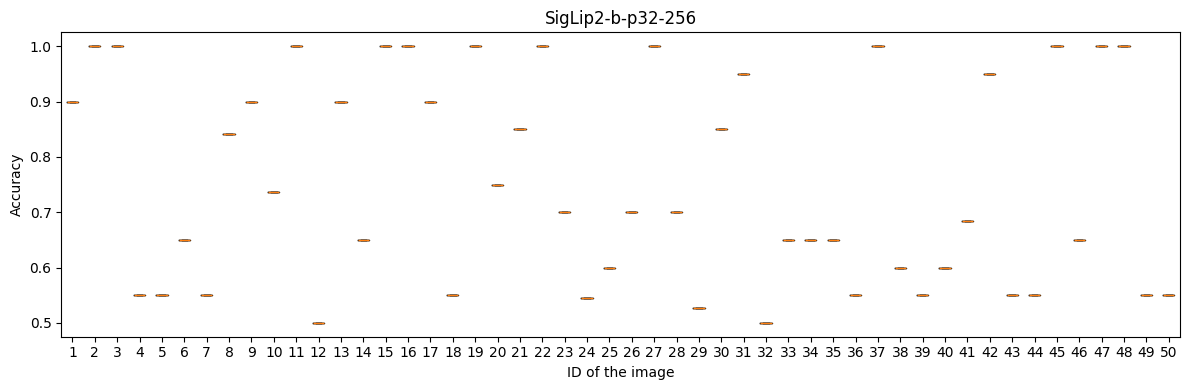

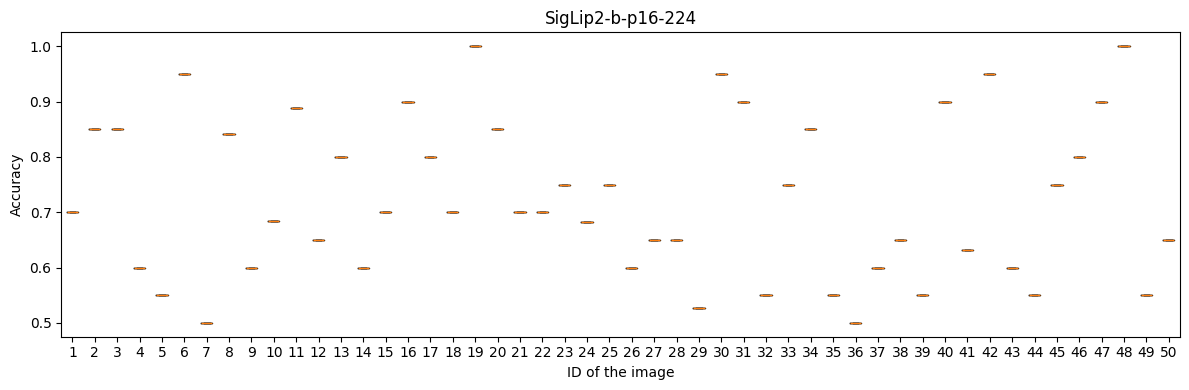

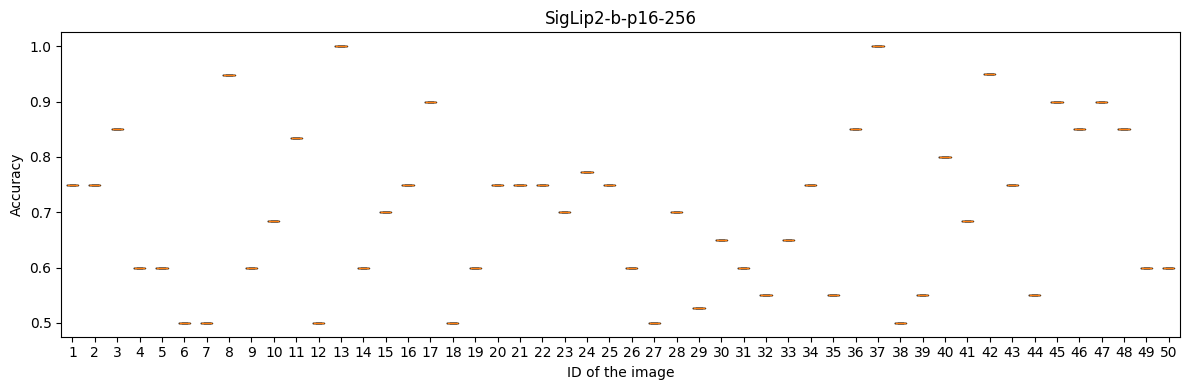

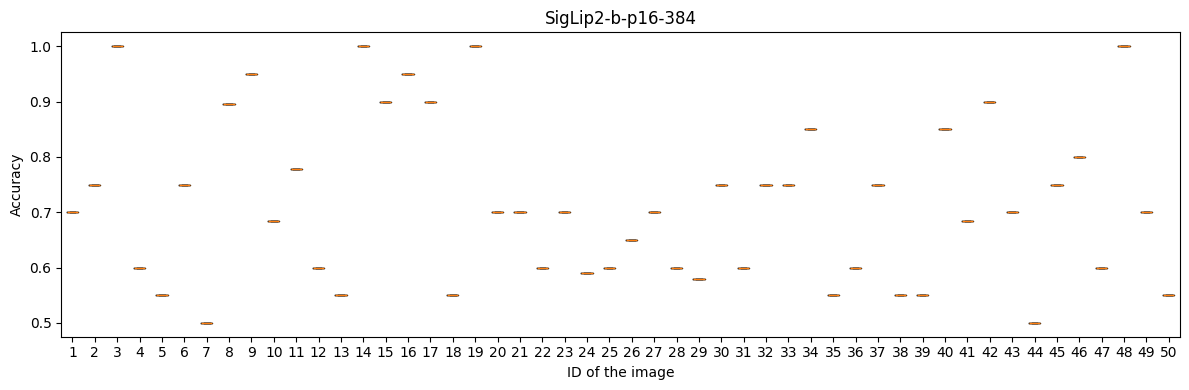

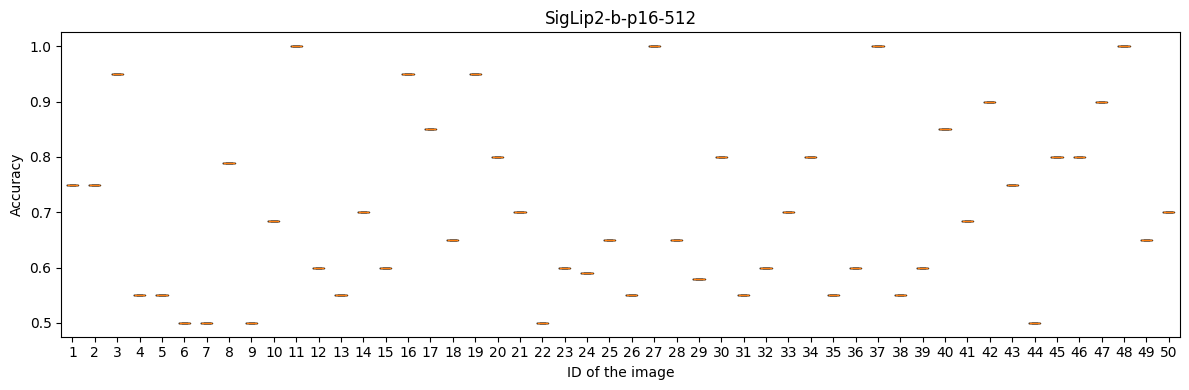

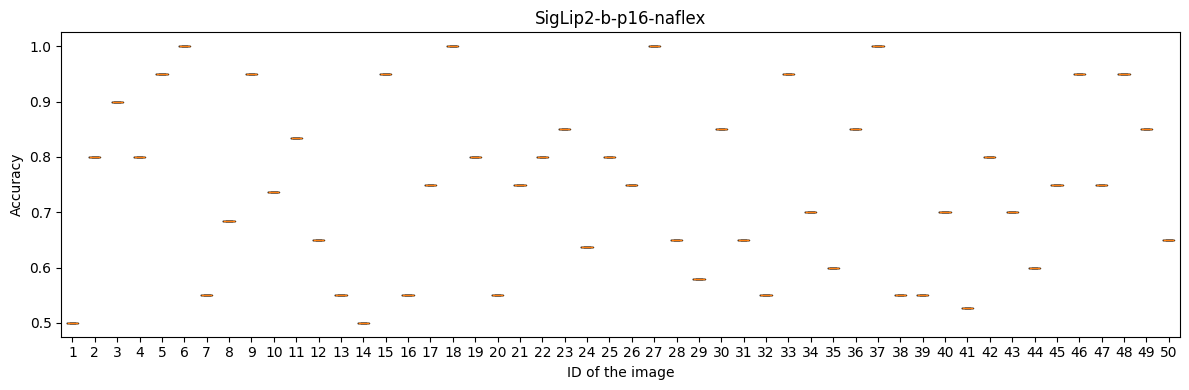

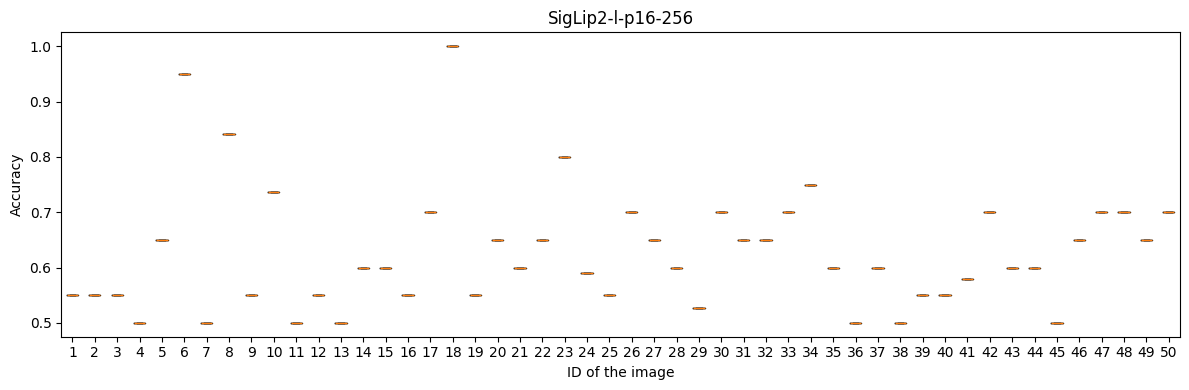

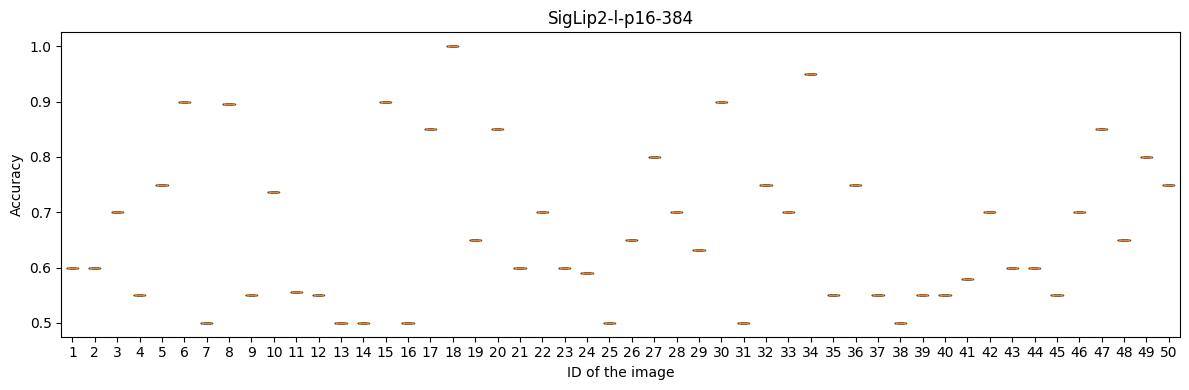

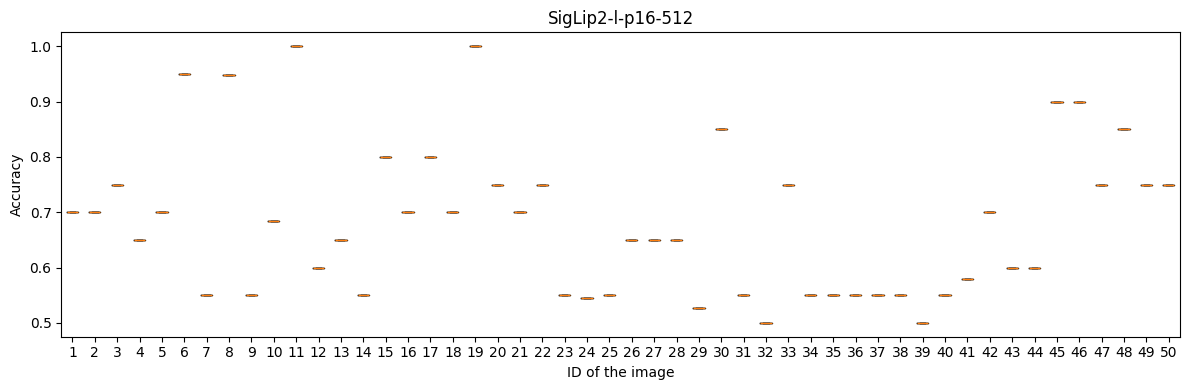

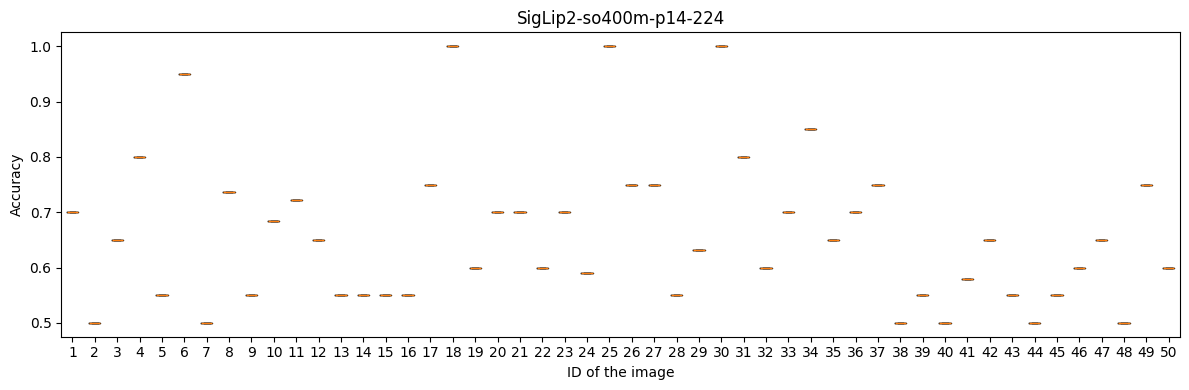

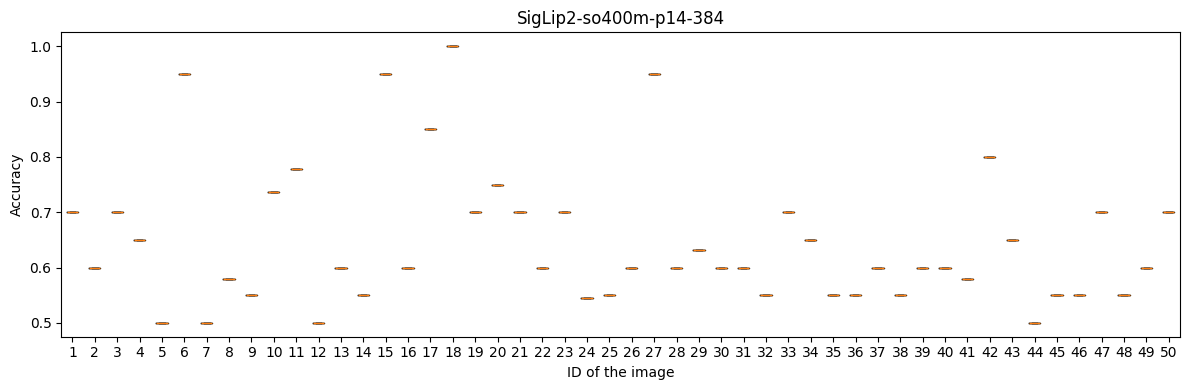

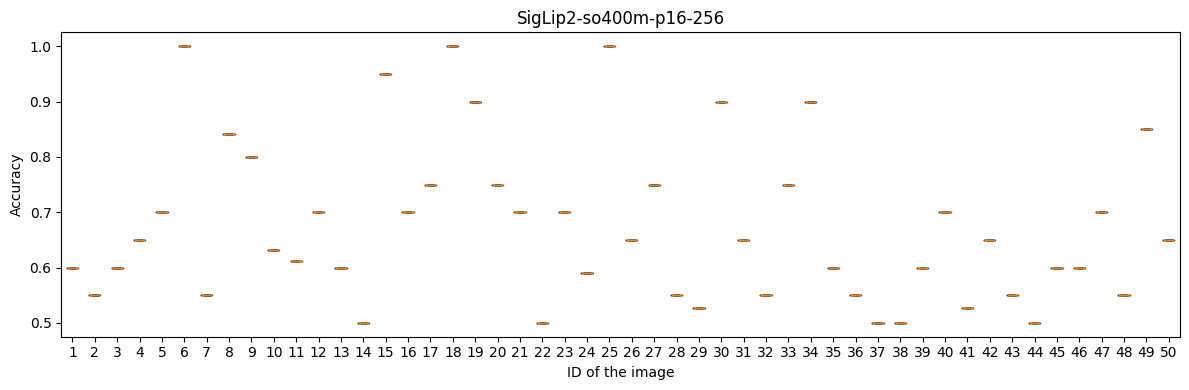

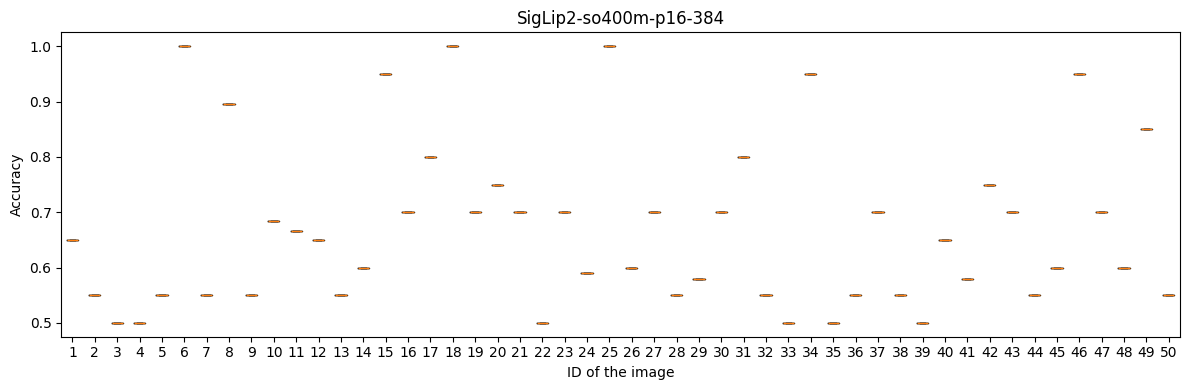

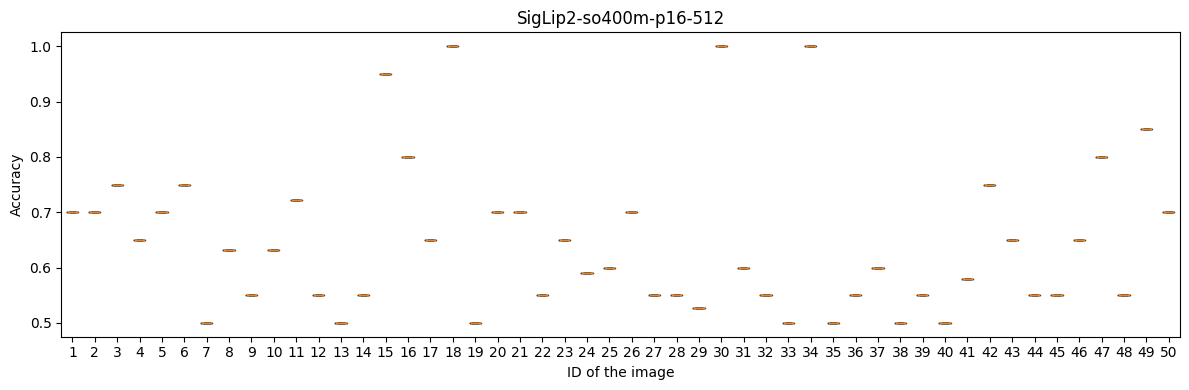

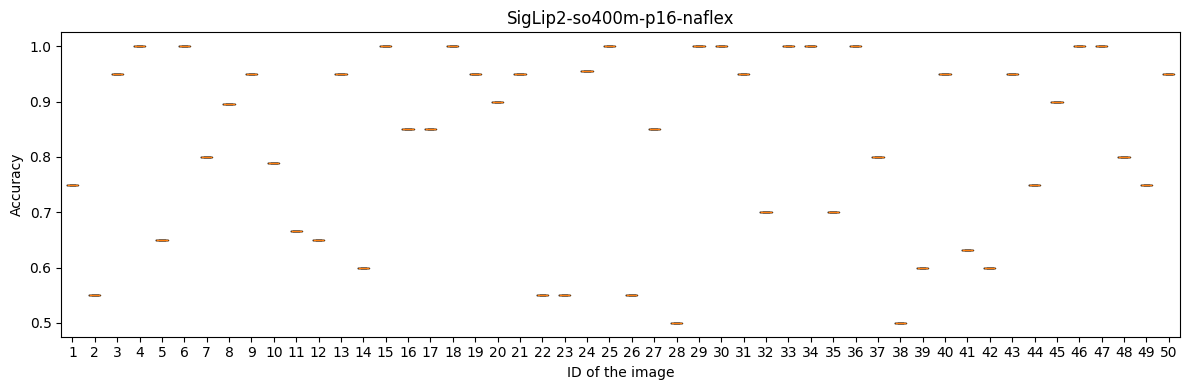

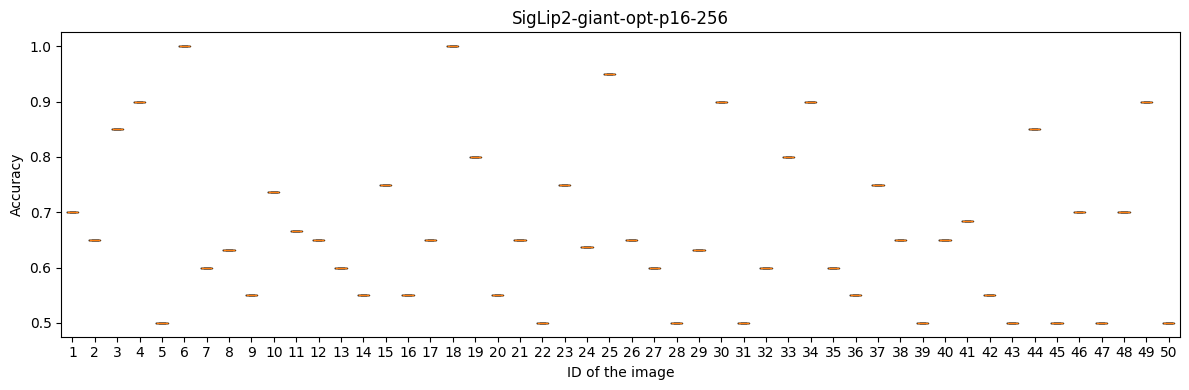

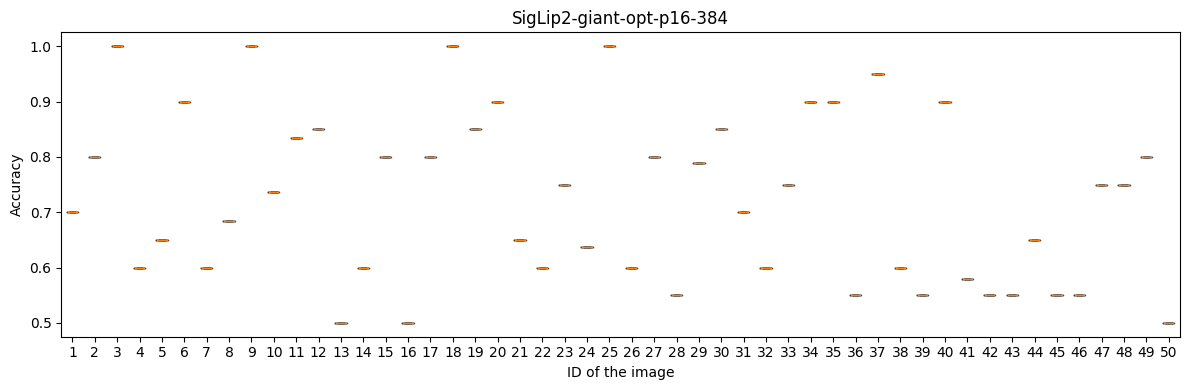

In [34]:
for i in range(len(method_names)):
  fig, ax = plt.subplots(figsize=(12, 4))  # Adjust figure size as needed
  ax.boxplot(accuracy_array_3D[i])
  ax.set_title(method_names[i])
  ax.set_xlabel('ID of the image')
  ax.set_ylabel('Accuracy')
  plt.tight_layout()  # Adjust layout to prevent overlapping elements
  plt.show()


# Ablation study on influence of batch size on the results

In [35]:
# Partially repeated code...
# could most likely pack this into seperate function, keeping it like this to make sure the results are reproducible,
# don't want unexpected effect, that I didn't observe during my initial evaluation.
if DO_ABLATION_STUDY:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for batch_size in BATCH_SIZE_ARRAY:
    for k, exp in enumerate(experiments_list):
      print("Model:", exp.model_path)
      print("Batch size:", batch_size)
      exp.init_model_n_processor()
      for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
          image = cv2.imread(str(image_path))
          players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
          pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
          batches = chunked(pillow_crops, batch_size)

          data = []
          start_time = time.perf_counter()
          for batch in batches:
            data.append(exp.forward(batch))
          end_time = time.perf_counter()
          exp.execution_time_list.append(end_time - start_time)

          data = np.concatenate(data)
          projections = Umap_reducer.fit_transform(data)
          clusters = np.array(KMeans_model.fit_predict(projections))

          total_time = time.perf_counter()
          exp.total_execution_time_list.append(total_time - start_time)

          result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
          exp.results_list.append(result.sum() / len(clusters))
          exp.clusters_list.append(clusters)
      exp.clean_up()
      experiments_list[k] = exp

      print("Mean: ", np.mean(exp.results_list))
      print("Mean execution time: ", np.mean(exp.execution_time_list))
      print("FPS: ", 1/np.mean(exp.execution_time_list))
      print(exp.results_list)
      print("\n")

    save_results_to_google_drive(experiments_list, batch_size)

In [36]:
if DO_ABLATION_STUDY:
  all_experiments_for_all_batches=[]
  for batch_size in BATCH_SIZE_ARRAY:
    all_experiments_for_all_batches.append(load_results_from_google_drive(batch_size))

  # Settings
  show_plot_for_each_exp = True
  show_percentage_differences = True
  show_percentage_differences_text = True

  accuracy_diff_list = []
  exec_time_diff_list = []
  total_exec_time_diff_list = []
  model_name_list = []

  for i_exp in range(len(all_experiments_for_all_batches[0])): # for experiment, every batch has so many methods in it
    mean_results_list = []
    mean_exec_time_list = []
    mean_total_exec_time_list = []
    for i_batch in range(len(all_experiments_for_all_batches)): # for batch size
      current_exp = all_experiments_for_all_batches[i_batch][i_exp]
      mean_results_list.append(np.mean(current_exp.results_list))
      mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
      mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

    if show_plot_for_each_exp:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
      ax1.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_results_list), label="Mean Accuracy")
      ax1.set_xlabel('Batch Size')
      ax1.set_ylabel('Mean Accuracy')
      ax1.legend()

      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_exec_time_list), label="Mean Exec time")
      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_total_exec_time_list), label="Mean Total Exec time")
      ax2.set_xlabel('Batch Size')
      ax2.set_ylabel('Mean Execution Time')
      ax2.legend()

      fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
      plt.show()

    if show_percentage_differences:
      mean_results_list = np.array(mean_results_list)
      mean_exec_time_list = np.array(mean_exec_time_list)
      mean_total_exec_time_list = np.array(mean_total_exec_time_list)

      accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
      exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
      total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

      accuracy_diff_list.append(accuracy_diff)
      exec_time_diff_list.append(exec_time_diff)
      total_exec_time_diff_list.append(total_exec_time_diff)
      model_name_list.append(current_exp.model_path)
      if show_percentage_differences_text:
        print(current_exp.model_path)
        print("Accuracy difference: ", accuracy_diff)
        print("Execution time difference: ", exec_time_diff)
        print("Total execution time difference: ", total_exec_time_diff)

  if show_percentage_differences:
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Accuracy Difference (%)")
    ax.set_title("Maximal accuracy difference across different models and batch sizes")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements


    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
    ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
    ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Time Difference (%)")
    ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
